# Code for Entry 5 - Module 7 

Entry for the Complex Systems ePortfolio created by group 6. 

**Project contributers**: Djourdan Johnson, Jacuqot Qiu, Lotte Michels, Nawat Nawati Azhati, Nuo Xu, Xuelin Wei

In [2]:
!pip install git+https://github.com/manu-mannattil/nolitsa.git # install nolista (for AMI/DMI)
!pip install pyrqa
!pip install pyunicorn
!pip install nolitsa

  Cloning https://github.com/manu-mannattil/nolitsa.git to /tmp/pip-req-build-bi7mzicn
  Running command git clone --filter=blob:none --quiet https://github.com/manu-mannattil/nolitsa.git /tmp/pip-req-build-bi7mzicn
  Resolved https://github.com/manu-mannattil/nolitsa.git to commit ccd9fab08a88fbc6ff63f0fae28730ccb74754de
  Preparing metadata (setup.py) ... done
  Created wheel for nolitsa: filename=nolitsa-0.1-py3-none-any.whl size=31083 sha256=3388936a6d1973b3a5226deec7fc8978eb683be8691f96f6a8f4e0ccb2ab37b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-e3tspwkq/wheels/5b/01/36/f0a7c45be6934f2b279bf267ab2ce9b7bc13ad1216835a68f5
Successfully built nolitsa
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.6/724.6 kB 17.8 MB/s eta 0:00:0000:01
  Created wheel for pyrqa: filename=PyRQA-8.1.0-py3-none-any.whl size=252444 sha256=d02d06285ad9b5c753399ccfc52c4683b9672d96e

In [3]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from nolitsa import delay, dimension
from scipy.signal import argrelextrema
from scipy.signal import detrend
%matplotlib inline

from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computation import RQAComputation, RPComputation
from pyrqa.metric import EuclideanMetric
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.analysis_type import Cross
from pyunicorn.timeseries.surrogates import Surrogates
from scipy.stats import sem, t

import copy
import random


The sensor data for hive 202204 contains 16037 measurements


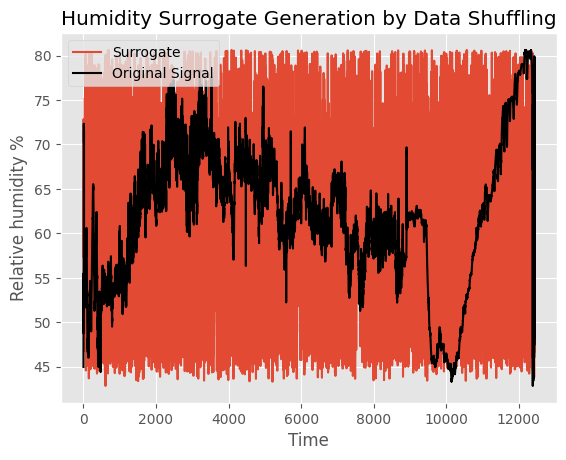

Generated an instance of the Surrogates class.


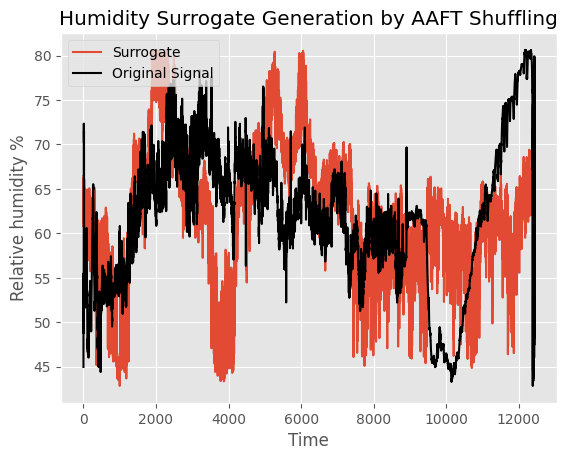

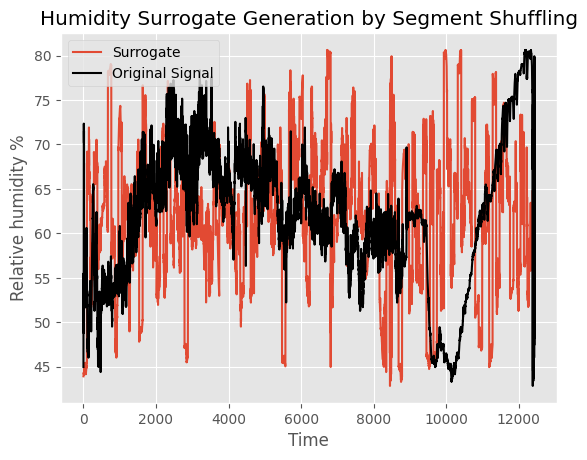

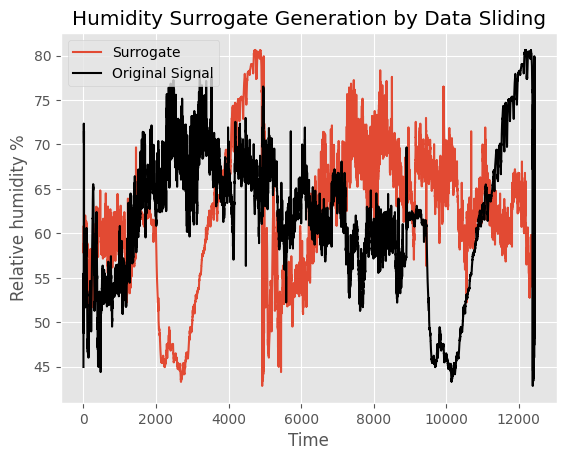

In [4]:
# Visualizing different surrogate generation methods 

# Load data
data = pd.read_csv("/kaggle/input/beehive-dataset/D1_sensor_data.csv", sep=",")

# Filter the data for tag_number 202204
hive = 202204 # ID = without the first 2, but the sensor data contains a number 2 before each ID
# 02204 is in Coté. GPS points: 46°44’30.21’’N, 71°28’28.41’’O
# usable beehives are: 202213 (noisy though), 202204, 202196 (some cutoff below -10 in the power measurements)
variables = ['temperature', 'humidity', 'tag_number', 'geolocation', 'hive_power', 'date', 'time', 'beehub_name']

hive_data = data.loc[data['tag_number'] == hive, variables].reset_index()
print('The sensor data for hive {} contains {} measurements'.format(hive, hive_data.shape[0]))
#print(hive_data.head(-5))

# Remove duplicate timepoints
hive_data['datetime'] = pd.to_datetime(hive_data['date'] + ' ' + hive_data['time'])
filtered_data = hive_data.drop_duplicates(subset='datetime')
#print('The sensor data for hive {} contains {} measurements after duplicate timepoint removal'.format(hive, filtered_data.shape[0]))

df = filtered_data

plt.style.use('ggplot')

# Select signal
hum = df['humidity'].values

# Data shuffling
shuffled_hum = copy.deepcopy(hum)
np.random.shuffle(shuffled_hum)

plt.figure()
plt.plot(shuffled_hum, label='Surrogate')
plt.plot(hum, color='black', label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Relative humidity %')
plt.title('Humidity Surrogate Generation by Data Shuffling')
plt.legend(loc='upper left')
plt.show()

# AAFT
hum_2d = hum.reshape(1, -1)
s = Surrogates(original_data=hum_2d)
aaft = s.AAFT_surrogates()[0] 

plt.figure()
plt.plot(aaft, label='Surrogate')
plt.plot(hum, color='black', label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Relative humidity %')
plt.title('Humidity Surrogate Generation by AAFT Shuffling')
plt.legend(loc='upper left')
plt.show()

# Segment shuffling
segment_hum = copy.deepcopy(hum)
blocksize = 96
blocks = [hum[i:i+blocksize] for i in range(0,len(hum),blocksize)] # segment the signal
random.shuffle(blocks) # shuffle the segments
segment_hum = [b for bs in blocks for b in bs] # concatenate the shuffled segments

plt.figure()
plt.plot(segment_hum, label='Surrogate')
plt.plot(hum, color='black', label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Relative humidity %')
plt.title('Humidity Surrogate Generation by Segment Shuffling')
plt.legend(loc='upper left')
plt.show()

# Data sliding
slided_hum = copy.deepcopy(hum)
cut_index = int(0.6*len(slided_hum)) # cut at 60%
slided_hum = np.concatenate((slided_hum[cut_index:], slided_hum[:cut_index])) 

plt.figure()
plt.plot(slided_hum, label='Surrogate')
plt.plot(hum, color='black', label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Relative humidity %')
plt.title('Humidity Surrogate Generation by Data Sliding')
plt.legend(loc='upper left')
plt.show()

plt.style.use('default')


In [5]:
# Load data, filter and process the data, replicating the steps from module 6 (copy/pasted)

file_path = "/kaggle/input/beehive-dataset/D1_sensor_data.csv"
df = pd.read_csv(file_path, parse_dates=["published_at"])
df = df[df["tag_number"] == 202204]
df = df.drop_duplicates(subset="published_at")
df = df.set_index("published_at")
df = df[["temperature", "humidity", "audio_density", "hive_power"]]
df_resampled = df.resample("15min").mean()
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_resampled),
    columns=["temperature_z", "humidity_z", "audio_density_z", "hive_power_z"],
    index=df_resampled.index
)
start_date = "2020-06-10"
end_date = "2020-10-15"
df_scaled = df_scaled.loc[start_date:end_date]
df_cleaned = df_scaled.dropna()
assert not df_cleaned.isnull().any().any(), "NaN values remain — not suitable for CRQA!"
threshold = 4
mask = (df_cleaned.abs() < threshold).all(axis=1)
df_final = df_cleaned[mask]
assert all(df_final[col].shape == df_final["temperature_z"].shape for col in df_final.columns), "Shape mismatch"
assert (df_final.index == df_final.index).all(), "Index mismatch"


In [6]:
# Tau estimation code from module 6 (copy/pasted)

temperature = df_final['temperature_z'].values
humidity = df_final['humidity_z'].values
audio_density = df_final['audio_density_z'].values
hive_power = df_final['hive_power_z'].values

max_tau = 100

dmi_temp = delay.dmi(temperature, maxtau=max_tau)
dmi_humid = delay.dmi(humidity, maxtau=max_tau)
dmi_audio = delay.dmi(audio_density, maxtau=max_tau)
dmi_power = delay.dmi(hive_power, maxtau=max_tau)

minima_temp = argrelextrema(dmi_temp, np.less)[0]
minima_humid = argrelextrema(dmi_humid, np.less)[0]
minima_audio = argrelextrema(dmi_audio, np.less)[0]
minima_power = argrelextrema(dmi_power, np.less)[0]

tau_temp = minima_temp[0] if len(minima_temp) > 0 else 10
tau_humid = minima_humid[0] if len(minima_humid) > 0 else 10
tau_audio = minima_audio[0] if len(minima_audio) > 0 else 10
tau_power = minima_power[0] if len(minima_power) > 0 else 10

print(f"Estimated τ for temperature: {tau_temp}")
print(f"Estimated τ for humidity: {tau_humid}")
print(f"Estimated τ for audio_density: {tau_audio}")
print(f"Estimated τ for hive_power: {tau_power}")


Estimated τ for temperature: 47
Estimated τ for humidity: 42
Estimated τ for audio_density: 31
Estimated τ for hive_power: 20


In [7]:
# Embedding estimation code from module 6 (copy/pasted)

tau_temp = 47
tau_audio = 31
tau_humid = 42
tau_power = 20 

dims = np.arange(1, 11)

temperature = df_final['temperature_z'].values
humidity = df_final['humidity_z'].values
audio = df_final['audio_density_z'].values
hive_power = df_final['hive_power_z'].values

fnn_temp = dimension.fnn(temperature, dim=dims, tau=tau_temp, metric='euclidean', window=2, maxnum=250)
fnn_humid = dimension.fnn(humidity, dim=dims, tau=tau_humid, metric='euclidean', window=2, maxnum=250)
fnn_audio = dimension.fnn(audio, dim=dims, tau=tau_audio,metric='euclidean', window=2, maxnum=250)
fnn_power = dimension.fnn(hive_power, dim=dims, tau=tau_power,metric='euclidean', window=2, maxnum=1000)



In [8]:
# Radius estimation code from module 6 (copy/pasted)

params = {
    'temperature_z':   {'tau': 47, 'm': 6},
    'humidity_z':      {'tau': 42, 'm': 6},
    'audio_density_z': {'tau': 31, 'm': 6},
    'hive_power_z':    {'tau': 20, 'm': 7},
}

def compute_rr(time_series_data, radius_value, embedding_dimension, time_delay):
    time_series = TimeSeries(time_series_data.flatten(),embedding_dimension=embedding_dimension, time_delay=time_delay)
    settings = Settings( time_series,analysis_type=Classic,neighbourhood=FixedRadius(radius_value),theiler_corrector=1)
    computation = RQAComputation.create(settings)
    result = computation.run()
    return result.recurrence_rate

params = {
    'temperature_z':   {'tau': 47, 'm': 6},
    'humidity_z':      {'tau': 42, 'm': 6},
    'audio_density_z': {'tau': 31, 'm': 6},
    'hive_power_z':    {'tau': 20, 'm': 7},
}

target_rr = 0.10
radii = np.linspace(0.1, 5.0, 100)

for var_name, p in params.items():
    ts_data = df_final[var_name].values
    rr_values = []
    for r in radii:
        try:
            rr = compute_rr(ts_data, r, embedding_dimension=p['m'], time_delay=p['tau'])
        except Exception as e:
            rr = np.nan
        rr_values.append(rr)

2 warnings generated.
/usr/local/lib/python3.11/dist-packages/pyopencl/__init__.py:519: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),


In [8]:
# COMPUTATIONS FOR SECTION 2

# True RQA code from module 6 (copy/pasted)

params = {
    'temperature_z':   {'tau': 47, 'm': 6, 'r': 0.15},
    'humidity_z':      {'tau': 42, 'm': 6, 'r': 0.9},
    'audio_density_z': {'tau': 31, 'm': 6, 'r': 0.8},
    'hive_power_z':    {'tau': 20, 'm': 7, 'r': 1.3},
}

for var_name, p in params.items():
    data_points = df_final[var_name].values
    time_series = TimeSeries( data_points,embedding_dimension=p['m'],time_delay=p['tau'])
    settings = Settings(time_series, analysis_type=Classic, neighbourhood=FixedRadius(p['r']), similarity_measure=EuclideanMetric,theiler_corrector=1)
    computation = RQAComputation.create(settings, verbose=True)
    result = computation.run()
    result.min_diagonal_line_length = 2
    result.min_vertical_line_length = 2
    result.min_white_vertical_line_length = 2
    print(f'\n===== RQA Results for {var_name} =====')
    print(result)


[Platform 'NVIDIA CUDA']
Vendor: NVIDIA Corporation
Version: OpenCL 3.0 CUDA 12.6.65
Profile: FULL_PROFILE
Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_3d_image_writes cl_khr_byte_addressable_store cl_khr_icd cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_khr_gl_event cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_nv_kernel_attribute cl_khr_device_uuid cl_khr_pci_bus_info cl_khr_external_semaphore cl_khr_external_memory cl_khr_external_semaphore_opaque_fd cl_khr_external_memory_opaque_fd


[Device 'Tesla T4']
Vendor: NVIDIA Corporation
Type: 4
Version: OpenCL 3.0 CUDA
Profile: FULL_PROFILE
Max Clock Frequency: 1590
Global Mem Size: 15828320256
Address Bits: 64
Max Compute Units: 40
Max Work Group Size: 1024
Max Work Item Dimensions: 3
Max Work Item Sizes: [1024, 1024, 64]
Local Mem Size: 4

## Univariate Surrogate testing

In [14]:
# COMPUTATIONS FOR SECTION 2

# Univariate surrogate testing

# Define functions for univariate/rqa surrogate testing (following the methods applied in module 6)

def rqa_surrogate(timeseriesx, method, emb, tau, rad):
    results = [] # placeholder for all surrogate RQA outcomes 
    ts = [] # placeholder for all generated surrogate signals
    if method == 'shuffle':
        for _ in range(1,21): # repeat shuffling/surrogate testing 20 times
            shuffled=copy.deepcopy(timeseriesx)
            np.random.shuffle(shuffled)
            shuffled_ts = TimeSeries(shuffled, embedding_dimension=emb, time_delay=tau)
            settings = Settings(shuffled_ts, analysis_type=Classic, neighbourhood=FixedRadius(rad), similarity_measure=EuclideanMetric)
            computation = RQAComputation.create(settings, verbose=False)
            result = computation.run()
            result.min_diagonal_line_length = 2
            result.min_vertical_line_length = 2
            result.min_white_vertical_line_length = 2
            results.append(result) 
            ts.append(shuffled_ts)
    elif method == 'aaft':
        for _ in range(1,21): # repeat shuffling/surrogate testing 20 times
            timeseries=copy.deepcopy(timeseriesx)
            timeseries = timeseries.reshape(1, -1)
            surrogate = Surrogates(original_data=timeseries, silence_level=2)
            shuffled = surrogate.AAFT_surrogates()[0]
            shuffled_ts = TimeSeries(shuffled, embedding_dimension=emb, time_delay=tau)
            settings = Settings(shuffled_ts, analysis_type=Classic, neighbourhood=FixedRadius(rad), similarity_measure=EuclideanMetric)
            computation = RQAComputation.create(settings, verbose=False)
            result = computation.run()
            result.min_diagonal_line_length = 2
            result.min_vertical_line_length = 2
            result.min_white_vertical_line_length = 2
            results.append(result)
            ts.append(shuffled_ts)
    return results, ts   

def surrogate_metrics(results, metrics=['recurrence_rate', 'determinism', 'laminarity', 'longest_diagonal_line', 'average_diagonal_line','trapping_time'], confidence=0.95):
    metric_dict = {metric: [] for metric in metrics}
    for metric in metrics:
        metric_distribution = [getattr(result, metric) for result in results]
        mean = np.mean(metric_distribution)
        stderr = sem(metric_distribution)
        n = len(metric_distribution)
        h = stderr * t.ppf((1 + confidence) / 2., n - 1)
        lower_bound = mean - h
        upper_bound = mean + h
        metric_dict[metric] = [mean, lower_bound, upper_bound]
    return metric_dict


In [10]:
# COMPUTATIONS FOR SECTION 2

# Apply univariate surrogate testing functions

# Select signals to apply surrogate tesing on
temperature = df_final['temperature_z'].values
humidity = df_final['humidity_z'].values
power = df_final['humidity_z'].values

# Parameters found in module 6:
# params = {
#     'temperature':   {'tau': 47, 'm': 6, 'r': 0.15},
#     'humidity':      {'tau': 42, 'm': 6, 'r': 0.9},
#     'audio_density': {'tau': 31, 'm': 6, 'r': 0.8},
#     'hive_power':    {'tau': 20, 'm': 7, 'r': 1.3},
# }

# Apply data shuffling
print('Data Shuffling Surrogate Results\n')

shuffle_temp_results, tst = rqa_surrogate(temperature, emb=6, tau=47, rad=0.15, method='shuffle')
shuffle_temp_metrics = surrogate_metrics(shuffle_temp_results)
print('temperature:',shuffle_temp_metrics,'\n')

shuffle_hum_results, ts = rqa_surrogate(humidity, emb=6, tau=42, rad=0.9, method='shuffle')
shuffle_hum_metrics = surrogate_metrics(shuffle_hum_results)
print('humidity:',shuffle_hum_metrics,'\n')

shuffle_power_results, ts = rqa_surrogate(power, emb=7, tau=20, rad=1.3, method='shuffle')
shuffle_power_metrics = surrogate_metrics(shuffle_power_results)
print('power:',shuffle_power_metrics,'\n')


# Apply AAFT
print('\nAAFT Surrogate Results\n')

aaft_temp_results, ts = rqa_surrogate(temperature, emb=6, tau=47, rad=0.15, method='aaft')
aaft_temp_metrics = surrogate_metrics(aaft_temp_results)
print('temperature:',aaft_temp_metrics,'\n')

aaft_hum_results, ts = rqa_surrogate(humidity, emb=6, tau=42, rad=0.9, method='aaft')
aaft_hum_metrics = surrogate_metrics(aaft_hum_results)
print('humidity:',aaft_hum_metrics,'\n')

aaft_power_results, ts = rqa_surrogate(power, emb=7, tau=20, rad=1.3, method='aaft')
aaft_power_metrics = surrogate_metrics(aaft_power_results)
print('power:',aaft_power_metrics,'\n')

Data Shuffling Surrogate Results

temperature: {'recurrence_rate': [0.004305816989938313, 0.004188064056004069, 0.004423569923872558], 'determinism': [0.008010441061733148, 0.007273299644007691, 0.008747582479458605], 'laminarity': [0.05325608368684624, 0.04897686930483966, 0.057535298068852825], 'longest_diagonal_line': [3.0, 2.848156075761784, 3.151843924238216], 'average_diagonal_line': [2.003891189727206, 2.0028010383969965, 2.004981341057415], 'trapping_time': [2.03755272004714, 2.028366498428619, 2.046738941665661]} 

humidity: {'recurrence_rate': [0.0026739021782706497, 0.0026344554248226254, 0.002713348931718674], 'determinism': [0.005066251872767774, 0.0049084871649056495, 0.005224016580629898], 'laminarity': [0.011929252786056908, 0.010921220453225649, 0.012937285118888168], 'longest_diagonal_line': [2.75, 2.5420791436865593, 2.9579208563134407], 'average_diagonal_line': [2.0029366379151052, 2.001817687588557, 2.0040555882416533], 'trapping_time': [2.009500477387704, 2.005455

In [9]:
# Trend check from module 6 (copy/pasted)

window_size = 96

for col in df_final.columns:
    series = df_final[col]
    rolling_mean = series.rolling(window=window_size, center=True, min_periods=1).mean()

df_detrended = df_final.copy()
df_detrended['temperature_z'] = detrend(df_final['temperature_z'].values, type='linear')
humidity_trend = df_final['humidity_z'].rolling(window=window_size, center=True, min_periods=1).mean()
df_detrended['humidity_z'] = df_final['humidity_z'] - humidity_trend
audio_trend = df_final['audio_density_z'].rolling(window=window_size, center=True, min_periods=1).mean()
df_detrended['audio_density_z'] = df_final['audio_density_z'] - audio_trend
hivepower_trend = df_final['hive_power_z'].rolling(window=window_size, center=True, min_periods=1).mean()
df_detrended['hive_power_z'] = df_final['hive_power_z'] - hivepower_trend

params = {
    'temperature_z':   {'tau': 47, 'm': 6, 'r': 0.15},
    'humidity_z':      {'tau': 42, 'm': 6, 'r': 0.9},
    'audio_density_z': {'tau': 31, 'm': 6, 'r': 0.8},
    'hive_power_z':    {'tau': 20, 'm': 7, 'r': 1.3},
}

for var_name, p in params.items():
    series = df_detrended[var_name].values
    time_series = TimeSeries(series,embedding_dimension=p['m'],time_delay=p['tau'])
    settings = Settings( time_series,analysis_type=Classic,neighbourhood=FixedRadius(p['r']), similarity_measure=EuclideanMetric, theiler_corrector=1)
    computation = RPComputation.create(settings)
    result = computation.run()
    rp_matrix = np.array(result.recurrence_matrix)



In [10]:
# CRQA Radius tuning from module 6 (copy/pasted)

temperature = df_detrended['temperature_z'].values
hive_power = df_detrended['hive_power_z'].values

embedding_dim = 7
tau = 33

ts_temp = TimeSeries(temperature, embedding_dimension=embedding_dim, time_delay=tau)
ts_power = TimeSeries(hive_power, embedding_dimension=embedding_dim, time_delay=tau)

radius_list = np.linspace(0.05, 1.0, 40)
rr_list = []

for r in radius_list:
    settings = Settings((ts_temp, ts_power),
                        analysis_type=Cross,
                        neighbourhood=FixedRadius(r),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=1)
    computation = RQAComputation.create(settings)
    result = computation.run()
    rr_list.append(result.recurrence_rate)


[Platform 'NVIDIA CUDA']
Vendor: NVIDIA Corporation
Version: OpenCL 3.0 CUDA 12.6.65
Profile: FULL_PROFILE
Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_3d_image_writes cl_khr_byte_addressable_store cl_khr_icd cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_khr_gl_event cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_nv_kernel_attribute cl_khr_device_uuid cl_khr_pci_bus_info cl_khr_external_semaphore cl_khr_external_memory cl_khr_external_semaphore_opaque_fd cl_khr_external_memory_opaque_fd


[Device 'Tesla T4']
Vendor: NVIDIA Corporation
Type: 4
Version: OpenCL 3.0 CUDA
Profile: FULL_PROFILE
Max Clock Frequency: 1590
Global Mem Size: 15828320256
Address Bits: 64
Max Compute Units: 40
Max Work Group Size: 1024
Max Work Item Dimensions: 3
Max Work Item Sizes: [1024, 1024, 64]
Local Mem Size: 4

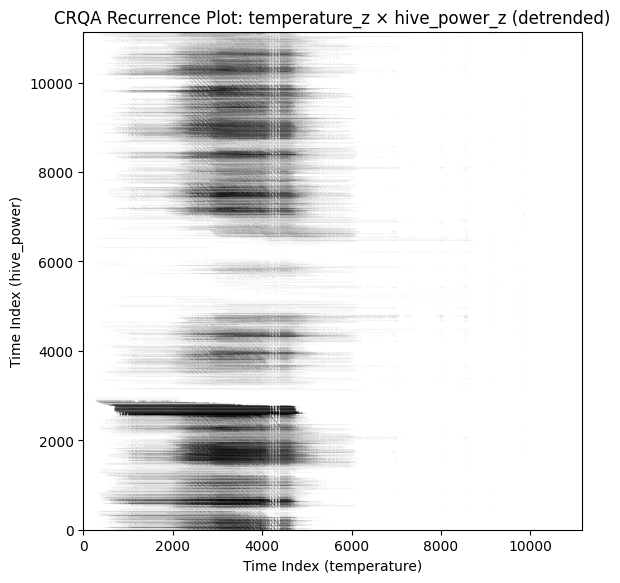

In [11]:
# COMPUTATIONS FOR SECTION 3

# True CRQA computation from module 6
time_series_temp = TimeSeries(temperature, embedding_dimension=7,time_delay=33)
time_series_power = TimeSeries(hive_power,embedding_dimension=7, time_delay=33)
settings = Settings((time_series_temp, time_series_power), analysis_type=Cross, neighbourhood=FixedRadius(0.8), similarity_measure=EuclideanMetric, theiler_corrector=1)
computation = RQAComputation.create(settings, verbose=True)
result = computation.run()
result.min_diagonal_line_length = 2
result.min_vertical_line_length = 2
result.min_white_vertical_line_length = 2

print(result)

rp_computation = RPComputation.create(settings)
rp_result = rp_computation.run()
rp_matrix = np.array(rp_result.recurrence_matrix_reverse)

plt.figure(figsize=(6, 6))
plt.imshow(rp_matrix, cmap='binary', origin='lower')
plt.title('CRQA Recurrence Plot: temperature_z × hive_power_z (detrended)')
plt.xlabel('Time Index (temperature)')
plt.ylabel('Time Index (hive_power)')
plt.tight_layout()
plt.show()


## Bivariate Surrogate Testing

In [12]:
# COMPUTATIONS FOR SECTION 3

# Bivariate surrogate testing

# Define functions for bivariate/crqa surrogate testing (following the methods applied in module 6)

def crqa_surrogate(timeseries_a, timeseries_b, method, emb, tau, rad):
    results = [] # placeholder for all surrogate RQA outcomes 
    ts = [] # placeholder for the generated surrogates 
    if method == 'segment_shuffle':
        #print(len(timeseries1))
        blocksize = 199 
        for _ in range(1,21): # repeat shuffling/surrogate testing 20 times
            timeseries1 = copy.deepcopy(timeseries_a)
            timeseries2 = copy.deepcopy(timeseries_b)
    
            blocks = [timeseries1[i:i+blocksize] for i in range(0,len(timeseries1),blocksize)]
            random.shuffle(blocks)
            shuffled1 = [b for bs in blocks for b in bs]
            ts.append(shuffled1) # store segment shuffled surrogate, used for windowed CRQA surrogate testing later!
            
            shuffled2 = timeseries2 # don't shuffle the second timeseries (only shuffle one)
            
            shuffled_ts1 = TimeSeries(shuffled1, embedding_dimension=emb, time_delay=tau)
            shuffled_ts2 = TimeSeries(shuffled2, embedding_dimension=emb, time_delay=tau)
            settings = Settings((shuffled_ts1, shuffled_ts2), analysis_type=Classic, neighbourhood=FixedRadius(rad), similarity_measure=EuclideanMetric)
            computation = RQAComputation.create(settings, verbose=False)
            result = computation.run()
            result.min_diagonal_line_length = 2
            result.min_vertical_line_length = 2
            result.min_white_vertical_line_length = 2
            results.append(result)

    elif method == 'slide': # Choose one point ~60% of the data, cut here, and append to beginning of time series
        for _ in range(1,21):
            timeseries1 = copy.deepcopy(timeseries_a)
            timeseries2 = copy.deepcopy(timeseries_b)
            
            cut_index = int(0.6*len(slided_hum)) # cut at 60%
            cut_index = np.random.randint(int(0.5*len(timeseries1)), int(0.7*len(timeseries1))) # sample cuts around 60%
            shuffled1 = np.concatenate((timeseries1[cut_index:], timeseries1[:cut_index])) 
            
            shuffled2 = timeseries2 # don't shuffle the second timeseries (only shuffle one)
        
            shuffled_ts1 = TimeSeries(shuffled1, embedding_dimension=emb, time_delay=tau)
            shuffled_ts2 = TimeSeries(shuffled2, embedding_dimension=emb, time_delay=tau)
            settings = Settings((shuffled_ts1, shuffled_ts2), analysis_type=Classic, neighbourhood=FixedRadius(rad), similarity_measure=EuclideanMetric)
            computation = RQAComputation.create(settings, verbose=False)
            result = computation.run()
            result.min_diagonal_line_length = 2
            result.min_vertical_line_length = 2
            result.min_white_vertical_line_length = 2
            results.append(result)
    
    return results, ts 


In [15]:
# COMPUTATIONS FOR SECTION 3

# Apply bivariate surrogate testing functions

# Select signals to apply surrogate tesing on
temperature = df_detrended['temperature_z'].values
power = df_detrended['hive_power_z'].values

# CRQA Parameters found in module 6: embedding = 7, delay = 33, radius = 0.7   

# Apply segment shuffling
segment_pt_results, segment_surrs = crqa_surrogate(temperature, power, emb=7, tau=33, rad=0.8, method='segment_shuffle')
segment_pt_metrics = surrogate_metrics(segment_pt_results)
print(segment_pt_metrics)


# Apply data sliding
slide_pt_results, _ = crqa_surrogate(temperature, power, emb=7, tau=33, rad=0.8, method='slide')
slide_pt_metrics = surrogate_metrics(slide_pt_results)
print(slide_pt_metrics)

{'recurrence_rate': [0.05713029097054791, 0.05488297404554718, 0.05937760789554865], 'determinism': [0.5889797819358391, 0.5757619241918892, 0.602197639679789], 'laminarity': [0.5985674839841497, 0.5861784829971849, 0.6109564849711145], 'longest_diagonal_line': [45.8, 42.58033586119666, 49.019664138803336], 'average_diagonal_line': [3.23303556882099, 3.1866417840073336, 3.2794293536346464], 'trapping_time': [3.471251829843664, 3.424414893243614, 3.5180887664437144]}
{'recurrence_rate': [0.0997765508335512, 0.09968501623872071, 0.0998680854283817], 'determinism': [0.6931467290250425, 0.6869400828455384, 0.6993533752045465], 'laminarity': [0.7014264335521309, 0.7009428077572496, 0.7019100593470121], 'longest_diagonal_line': [50.0, 50.0, 50.0], 'average_diagonal_line': [3.5675516153055518, 3.5347534656474866, 3.600349764963617], 'trapping_time': [3.9171532743658397, 3.916411855738044, 3.9178946929936354]}


## Windowed CRQA and Surrogate Testing

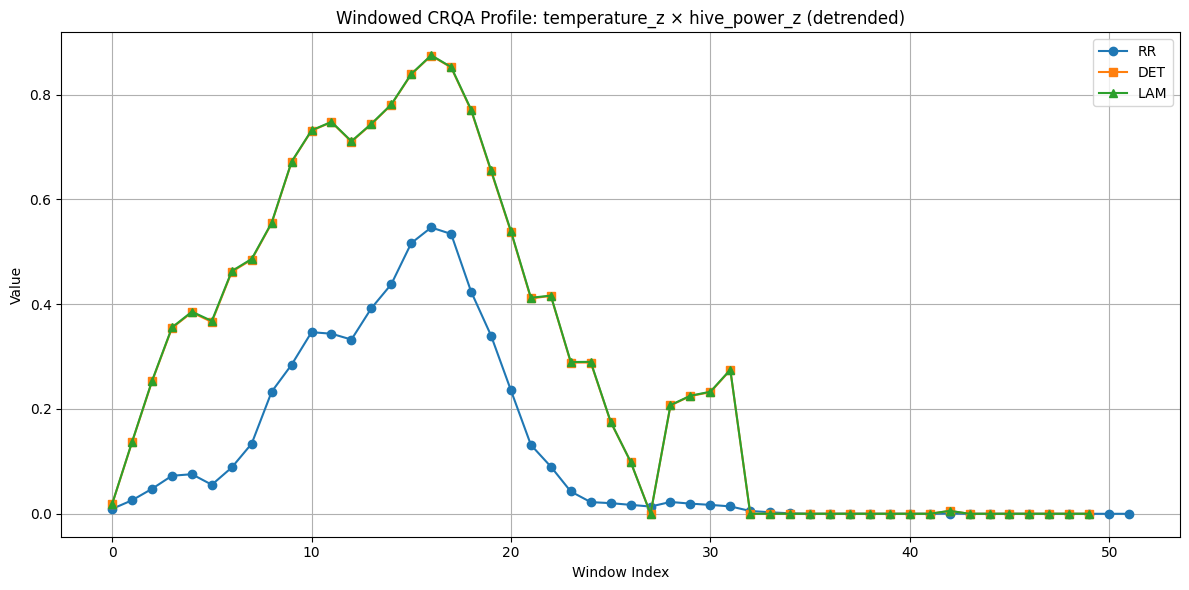

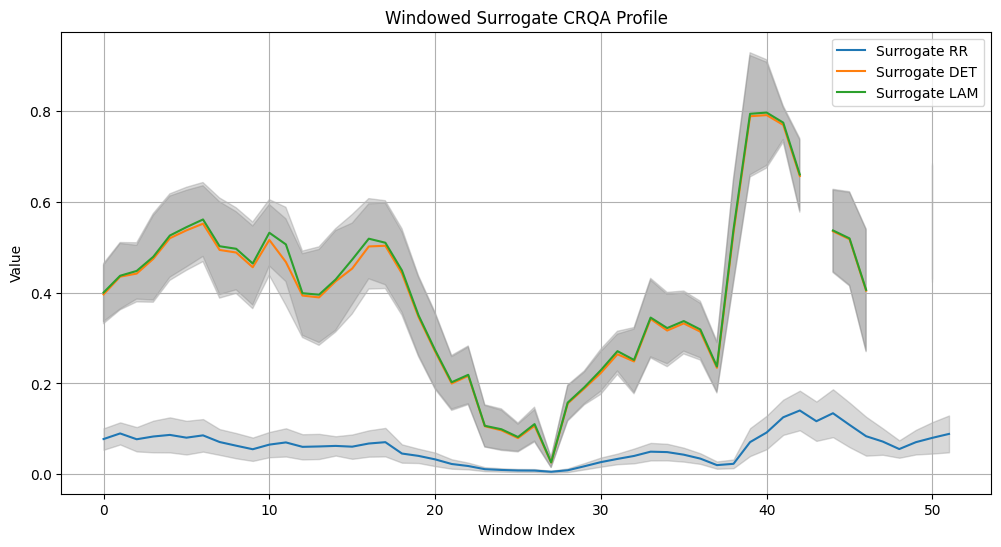

In [16]:
# COMPUTATIONS FOR SECTION 4

# Set parameters
window_size = 1000    
window_step = 200     
embedding_dim = 7     
tau = 33              
radius = 0.8          

# Load detrended time series
ts1 = df_detrended['temperature_z'].values
ts2 = df_detrended['hive_power_z'].values

# Calculate number of windows
n_windows = (len(ts1) - window_size) // window_step + 1

# Containers for results
rr_list = []
det_list = []
lam_list = []

for i in range(n_windows):
    start = i * window_step
    end = start + window_size

    segment1 = ts1[start:end]
    segment2 = ts2[start:end]

    ts_obj1 = TimeSeries(segment1, embedding_dimension=embedding_dim, time_delay=tau)
    ts_obj2 = TimeSeries(segment2, embedding_dimension=embedding_dim, time_delay=tau)

    settings = Settings((ts_obj1, ts_obj2),
                        analysis_type=Cross,
                        neighbourhood=FixedRadius(radius),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=1)

    computation = RQAComputation.create(settings)
    result = computation.run()

    rr_list.append(result.recurrence_rate)
    det_list.append(result.determinism)
    lam_list.append(result.laminarity)

# Convert to DataFrame
results_df = pd.DataFrame({
    'window': np.arange(n_windows),
    'RR': rr_list,
    'DET': det_list,
    'LAM': lam_list
})

# Plot Windowed CRQA Profiles
plt.figure(figsize=(12, 6))
plt.plot(results_df['window'], results_df['RR'], label='RR', marker='o')
plt.plot(results_df['window'], results_df['DET'], label='DET', marker='s')
plt.plot(results_df['window'], results_df['LAM'], label='LAM', marker='^')
plt.xlabel('Window Index')
plt.ylabel('Value')
plt.title('Windowed CRQA Profile: temperature_z × hive_power_z (detrended)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Windowed surrogate testing
surr_rr_distr = []
surr_det_distr = []
surr_lam_distr = []

segment_surrs
for temp_surr in segment_surrs:
    ts1 = temp_surr

    surr_rr_list = []
    surr_det_list = []
    surr_lam_list = []

    for i in range(n_windows):
        start = i * window_step
        end = start + window_size
    
        segment1 = ts1[start:end]
        segment2 = ts2[start:end]
    
        ts_obj1 = TimeSeries(segment1, embedding_dimension=embedding_dim, time_delay=tau)
        ts_obj2 = TimeSeries(segment2, embedding_dimension=embedding_dim, time_delay=tau)
    
        settings = Settings((ts_obj1, ts_obj2),
                            analysis_type=Cross,
                            neighbourhood=FixedRadius(radius),
                            similarity_measure=EuclideanMetric,
                            theiler_corrector=1)
    
        computation = RQAComputation.create(settings)
        result = computation.run()
    
        surr_rr_list.append(result.recurrence_rate)
        surr_det_list.append(result.determinism)
        surr_lam_list.append(result.laminarity)

    surr_rr_distr.append(surr_rr_list)
    surr_det_distr.append(surr_det_list)
    surr_lam_distr.append(surr_lam_list)


surr_rr_distr = np.array(surr_rr_distr)
surr_det_distr = np.array(surr_det_distr)
surr_lam_distr = np.array(surr_lam_distr)

rr_surr = np.mean(surr_rr_distr, axis=0)
det_surr = np.mean(surr_det_distr, axis=0)
lam_surr = np.mean(surr_lam_distr, axis=0)

rr_stderr = sem(surr_rr_distr, axis=0)
det_stderr = sem(surr_det_distr, axis=0)
lam_stderr = sem(surr_lam_distr, axis=0)

confidence = 0.95 # 95% CI (using t-distribution)
n = surr_rr_distr.shape[0]

rr_h = rr_stderr * t.ppf((1 + confidence) / 2., n - 1)
det_h = det_stderr * t.ppf((1 + confidence) / 2., n - 1)
lam_h = lam_stderr * t.ppf((1 + confidence) / 2., n - 1)


plt.figure(figsize=(12, 6))
# plt.plot(results_df['window'], results_df['RR'], label='RR', marker='o')
# plt.plot(results_df['window'], results_df['DET'], label='DET', marker='s')
# plt.plot(results_df['window'], results_df['LAM'], label='LAM', marker='^')
plt.plot(results_df['window'], rr_surr, label='Surrogate RR')
plt.fill_between(results_df['window'], rr_surr - rr_h, rr_surr + rr_h, color='gray', alpha=0.3)
plt.plot(results_df['window'], det_surr, label='Surrogate DET')
plt.fill_between(results_df['window'], det_surr - det_h, det_surr + det_h, color='gray', alpha=0.3)
plt.plot(results_df['window'], lam_surr, label='Surrogate LAM')
plt.fill_between(results_df['window'], lam_surr - lam_h, lam_surr + lam_h, color='gray', alpha=0.3)
plt.title('Windowed Surrogate CRQA Profile')
plt.ylabel('Value')
plt.xlabel('Window Index')
plt.grid(True)
plt.legend()
plt.show()


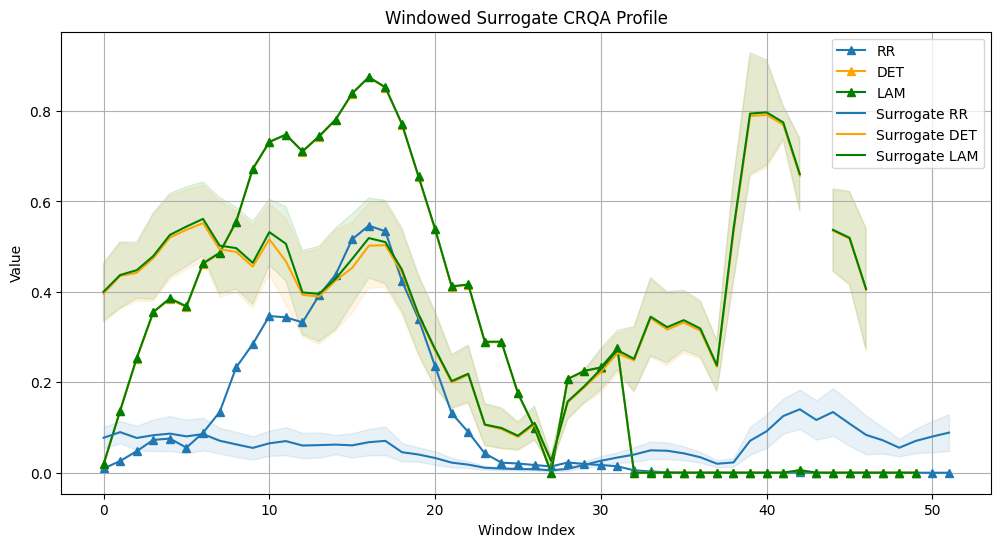

In [17]:
# VISUALIZATIONS FOR SECTION 4

plt.figure(figsize=(12, 6))
plt.plot(results_df['window'], results_df['RR'], label='RR', marker='^', color='#1f77b4')
plt.plot(results_df['window'], results_df['DET'], label='DET', marker='^', color='orange')
plt.plot(results_df['window'], results_df['LAM'], label='LAM', marker='^', color='green')
plt.plot(results_df['window'], rr_surr, label='Surrogate RR', color='#1f77b4')
plt.fill_between(results_df['window'], rr_surr - rr_h, rr_surr + rr_h, color='#1f77b4', alpha=0.1)
plt.plot(results_df['window'], det_surr, label='Surrogate DET', color='orange')
plt.fill_between(results_df['window'], det_surr - det_h, det_surr + det_h, color='orange', alpha=0.1)
plt.plot(results_df['window'], lam_surr, label='Surrogate LAM', color='green')
plt.fill_between(results_df['window'], lam_surr - lam_h, lam_surr + lam_h, color='green', alpha=0.1)
plt.title('Windowed Surrogate CRQA Profile')
plt.ylabel('Value')
plt.xlabel('Window Index')
plt.grid(True)
plt.legend()
plt.show()


In [18]:
# COMPUTATIONS FOR SECTION 4

# Find window where laminarity is highest (peak in the plot)
index_max = lam_list.index(max(lam_list)) 
#print(index_max)

# Compute starting and ending indices in the data corresponding to the peak in the plot
start = (index_max-6) * window_step 
end = start + (window_size*3)
print(df_final.iloc[start:end].index)

DatetimeIndex(['2020-07-01 06:45:00+00:00', '2020-07-01 07:00:00+00:00',
               '2020-07-01 07:15:00+00:00', '2020-07-01 07:30:00+00:00',
               '2020-07-01 08:00:00+00:00', '2020-07-01 08:15:00+00:00',
               '2020-07-01 08:30:00+00:00', '2020-07-01 08:45:00+00:00',
               '2020-07-01 09:00:00+00:00', '2020-07-01 09:15:00+00:00',
               ...
               '2020-08-06 02:30:00+00:00', '2020-08-06 03:45:00+00:00',
               '2020-08-06 04:00:00+00:00', '2020-08-06 04:15:00+00:00',
               '2020-08-06 04:30:00+00:00', '2020-08-06 04:45:00+00:00',
               '2020-08-06 05:00:00+00:00', '2020-08-06 05:15:00+00:00',
               '2020-08-06 05:30:00+00:00', '2020-08-06 05:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='published_at', length=3000, freq=None)
